# DLSP25U: Introduction to Deep Learning

**Name:** Sara Vargas


**Instructions:**

In this notebook, you will be asked to write code and answer questions.  
Place all responses under the **Solution** headers.

---

This second assignment is aimed at coding the soft perceptron algorithm. 
Hereafter we import some useful libraries and set the random seed for reproducibility.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

SEED = 0
np.random.seed(SEED)

## The Soft Perceptron (binary)

The soft perceptron is a variant of the original perceptron in which the step function (or Heaviside function) is replaced with the sigmoid function, defined as:

$$
\sigma(s) = \frac{1}{1 + \exp(- s)}
$$

This has mutliple consequences, the most important being that the perceptron's output is no longer binary $\{0, 1\}$ but continuous in the range $(0, 1)$.

$$
\begin{align*}
    \text{Perceptron}_{\text{hard}} &: \mathbb{R}^N \to \{ 0, 1\} \\
    \text{Perceptron}_{\text{soft}} &: \mathbb{R}^N \to ( 0, 1 )
\end{align*}
$$

This allows us not only to classify the input data but also to provide a **level of confidence** in the classification. Points closer to the decision boundary will be less confidently classified than points further away.

More formally, we can describe the soft perceptron as the following (*discriminative*) model:

$$
\begin{align*}
    y &\sim \text{Bernoulli}(\tilde{y}) \\
    \tilde{y} &= \mathbb{P}(y = 1 \mid x) = \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))
\end{align*}
$$
<!-- 
This means that for each input $x$, we can compute its probability to belong to class $1$ and then classify it based on a threshold  $\tau$. One could rewrite the above as:

$$
\hat{y} = \begin{cases}
    1 & \text{if } \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \tau \\
    0 & \text{otherwise}
\end{cases}
$$

or, using the Iverson bracket:

$$
\begin{align*}
    \hat{y} &= [ \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \tau ] \\
    &= \left[ \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) \geq \frac{1}{2} \right] \\
\end{align*}
$$

$\tau = \frac{1}{2}$ guarantees that the decision rule is equivalent to the one of the hard perceptron. -->

The update rule for the soft perceptron is the same as the original perceptron, hence:  
$$
\begin{equation*}
    \boldsymbol{w} \gets \boldsymbol{w} + (y - \tilde{y}) \boldsymbol{f}(x)
\end{equation*}
$$


The image below illustrates an example of a soft perceptron's output probability for study hours and exam pass probability.
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Exam_pass_logistic_curve.svg/1280px-Exam_pass_logistic_curve.svg.png" alt="Image description" width=500 />
</p>



The soft perceptron gives us in output a probability of the input belonging to class $1$. Once we have the probability, how should we **decide** the class?
In the original, or "hard", perceptron we computed the decision boundary $\boldsymbol{w}^{\top} \boldsymbol{f}(x) = 0$ and classified the input based on the fact that the output was on the positive or negative side of the boundary. This can be seen as computing the value $\sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))$ and comparing it to a threshold $\tau = 0$, if it is greater than the threshold we classify the input as $1$, otherwise as $0$.

The question is: 

to be consistent with the original perceptron, what should the threshold be for the soft perceptron?

**Solution**

The threshold for the soft perceptron is:

$$
\begin{align*}
    \boldsymbol{w}^{\top} \boldsymbol{f}(x) &= 0 \\
    \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) &= \sigma(0) \\
    \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x)) &= \frac{1}{2}
\end{align*}
$$

### Exercise 1

The first exercise requires you to implement the soft perceptron algorithm using a Python class. Below is a template for the `SoftPerceptron` class. You need to implement the methods `train`, `predict`, and `decide`:

- The `train` method should implement the perceptron learning algorithm. It should take the training dataset as input and process all pairs \((x, y)\), updating the weights accordingly.  
- The `predict` method should take a data point `f` as input and return the predicted probability of the class \(y = 1\), i.e., \(\mathbb{P}(y = 1 \mid x)\).  
- The `decide` method should take a data point `f` as input and return the predicted label.  

In [4]:
class SoftPerceptron:
    def __init__(self, n_features):
        # You can either include the bias term in the weights vector or not
        # but consider adapting the predict method accordingly
        self.w = np.zeros(n_features)
        self.b = 0
        self.threshold = 0.5

    def predict(self, f):
        s= np.dot(self.w, f)+ self.b 
        py= 1/(1+np.exp(-s))
        return py

    def train(self, F, y):
        losses=0
        for j in range(50):
            for f, label in zip(F, y):
                py=self.predict(f)
                losses+= self.BCE(label, py)
                update= label-py
                self.w+= update*f
                self.b+=update
        return losses/len(y)
   
    def BCE(self, y, py):
        epsilon = 1e-10  # Small value to prevent log(0)
        py = np.clip(py, epsilon, 1 - epsilon)
        return -y * np.log(py) - (1 - y) * np.log(1 - py)
    
    def decide(self, f):
        predict= self.predict(f)
        if(predict>self.threshold):
            return 1
        else: 
            return 0

    def AverageBCE(self, F, y):
        bce_loss=0
        for f, yi in zip(F, y):
            BCE= self.BCE(yi, self.predict(f))
            bce_loss +=BCE
        return bce_loss/len(y)

    def accuracy(self, F, y):
        loss=0
        for f, yi in zip(F, y):
            d= self.decide(f)
            loss += np.abs(d-yi)
        return 1-loss/len(y)


### Data Generation

We will generate a dataset $D = \{ (x_n, y_n) \}_{n=1}^{N=500}$ where $\boldsymbol{f}(x_n) \in \mathbb{R}^2$ and $y_n \in \{0, 1\}$.
The dataset will be generated in the following way:
$$\boldsymbol{f}(x_n) \sim \begin{cases}
\mathcal{N}\left(\begin{pmatrix} 1 \\ 1\end{pmatrix}, \sigma^2 \mathbb{I}_2 \right) & \text{if } y_n = 1 \\
\mathcal{N}\left(\begin{pmatrix}-1 \\ -1\end{pmatrix}, \sigma^2 \mathbb{I}_2 \right) & \text{if } y_n = 0
\end{cases}
$$

The function `generate_dataset` does exactly this and you do not have to modify it.

In [29]:
def generate_dataset(
    n_samples = 1000,
    sigma = 1,
    mean = 1
):
    # Generate mean vectors
    mean_positive = np.array([mean, mean])
    mean_negative = np.array([-mean, -mean])

    # Generate covariance matrix
    covariance_matrix = sigma**2 * np.eye(2)

    # Generate labels
    y = np.random.choice([0, 1], size=n_samples)

    # Generate data points based on labels
    F = np.array([
        np.random.multivariate_normal(mean_positive, covariance_matrix) if label == 1 
        else np.random.multivariate_normal(mean_negative, covariance_matrix) 
        for label in y
    ])

    return F, y

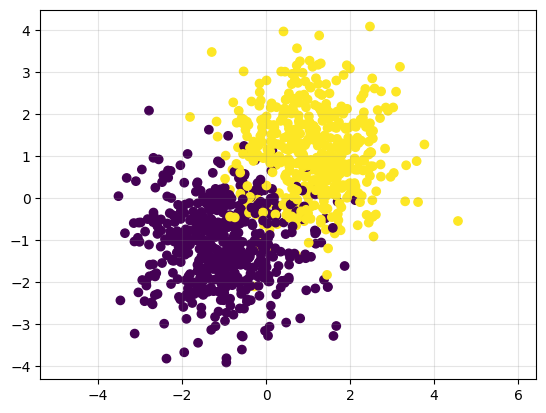

In [30]:
F, y = generate_dataset()

plt.scatter(F[:, 0], F[:, 1], c=y)
plt.grid(c='.5', alpha=.2)
plt.axis('equal');

### Exercise 2

Now you are asked to:
- Split the dataset into a training and a test set
- Train the soft perceptron on the training set
- Evaluate the accuracy of the model on both the training and test set

In [7]:

from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test = train_test_split(F, y,test_size=0.2, stratify=y)
sf= SoftPerceptron(len(X_train[0]))
sf.train(X_train, y_train)
training= sf.accuracy(X_train, y_train)
accuracy= sf.accuracy(X_test, y_test)

print(f'Training set accuracy: {training} \nTest set accuracy {accuracy}')

Training set accuracy: 0.9325 
Test set accuracy 0.9299999999999999


### Exercise 3

In the previous assignemnt, we have seen that visualizing the decision boundary of the hard perceptron was a useful way to understand how the model works.
Now, we would like to go further:
- Draw curves on the input space where the model predicts $y = 1$ with probabilities $0.1, 0.2, \dots, 0.9$.  
- Label these equal-probability curves with their respective probability values and shade the regions between them.  
- Answer the following questions:  
    - Are the equal-probability curves parallel? Why or why not?  
    - Are the shaded regions between the curves equally spaced? Why or why not?  


*Note: Since the soft perceptron is a linear model and the data lies in $\mathbb{R}^2$, both the decision boundary and the equal-probability curves are straight lines.*


**Useful functions for this exercise:**  
- `numpy.meshgrid`  
- `matplotlib.pyplot.contourf`  
- `matplotlib.pyplot.contour`  
- `matplotlib.pyplot.clabel`  

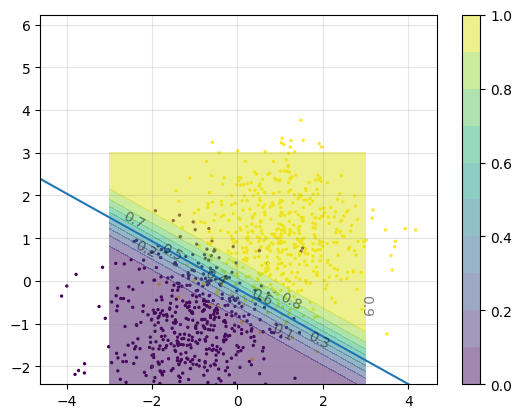

In [28]:
def plot(F,y, sf):
    plt.scatter(F[:, 0], F[:, 1], c=y, s=2)
    plt.grid(c='.5', alpha=.2)
    plt.axis('equal')
    weights= sf.w
    
    w1=weights[0]
    w2= weights[1] 
    b= sf.b  
    
    x= np.linspace(-3,3,100)
    y= np.linspace(-3,3,100)
    x1 = np.linspace(-5,5,10000)
    plt.plot(x1, - w1/w2 * x1 - b/w2) #p=0.5

    x_1, y_1 = np.meshgrid(x, y) 
   
    '''
    Z=[]
    for f1, f2 in zip(x_1, y_1):
        f=[f1, f2]
        Z.append(sf.predict(f))
    '''
    
    s = w1 * x_1 + w2 * y_1 + b
    Z = 1/(1+np.exp(-s))
    contours = plt.contourf(x_1,y_1, Z ,10, alpha=0.5)
    plt.clabel(contours, fontsize=10,colors='black')
    plt.colorbar() 
    plt.ylim(np.min(F[1, :])-0.5, np.max(F[1, :])+0.5)
    plt.xlim(np.min(F[:, 0])-0.5, np.max(F[:, 0])+0.5)
   
            

plot(F,y,sf)

    



The equal probability curves are parallel because they all share the same slope from the weights trained by the perceptron. Since the soft perceptron is a linear model and the data lies in R2 the decision boundary and equal probabilitiyt lines are straight lines and show line from the decision boundary shifted by the bias term. 

I plotted the isolines of when the Z, which is the probability of y=1 is constant in the predict function. The lines are parallel due to 

### Exercise 4

In this exercise, we will study how the sigmoid function compresses or expands as the variance of the data changes. We will explore two regimes:

- **When the data is linearly separable**  
- **When the data is not linearly separable**  

The two datasets are provided, and you do not need to modify them.


For each of the two cases, you are asked to:
- Train three soft perceptrons on the training sets
- Plot the decision boundary along with the equal-probability lines.  


After completing these tasks, answer the following questions:
- How does the shape of the sigmoid function change in the first regime as the variance increases?  
- How does the shape of the sigmoid function change in the second regime as the variance increases?  


**Note:** In this exercise, ignore the orientation of the decision boundary and focus on the shape of the sigmoid function.  


**Useful Python functions for this exercise:**  
- `matplotlib.pyplot.subplot`    

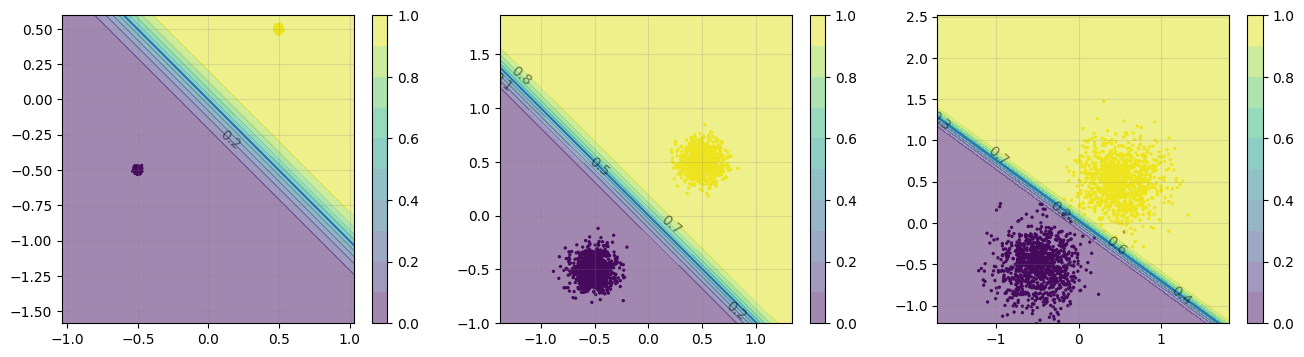

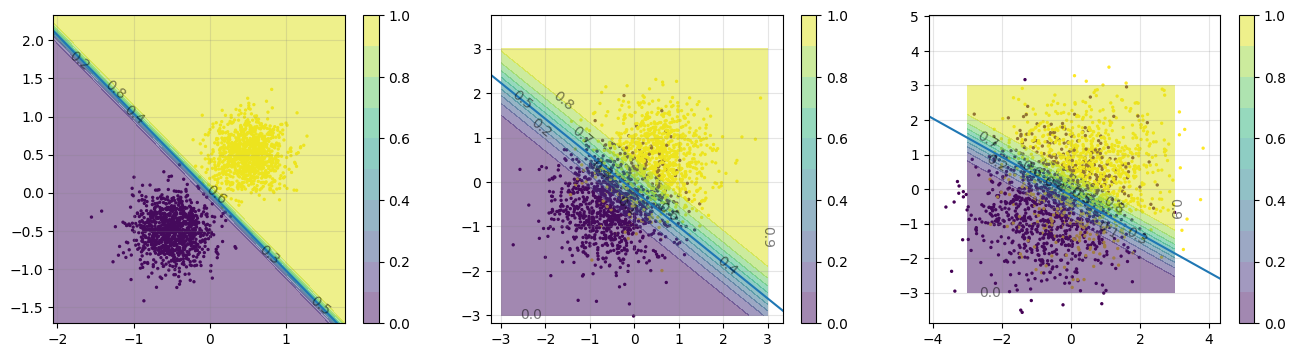

In [9]:
n_samples = 2000

fig = plt.figure(figsize = (16,4))
# First regime
F_1, y_1 = generate_dataset(n_samples=n_samples, sigma=0.01, mean=.5)
sf1= SoftPerceptron(len(F_1[0]))
sf1.train(F_1, y_1)
plt.subplot(1,3,1)

plot(F_1, y_1,sf1)

F_2, y_2 = generate_dataset(n_samples=n_samples, sigma=.1, mean=.5)
sf2= SoftPerceptron(len(F_2[0]))
sf2.train(F_2, y_2)
plt.subplot(1,3,2)
plot(F_2, y_2,sf2)

F_3, y_3 = generate_dataset(n_samples=n_samples, sigma=.25, mean=.5)
sf3= SoftPerceptron(len(F_3[0]))
sf3.train(F_3, y_3)
plt.subplot(1,3,3)
plot(F_3, y_3,sf3)

plt.show()
fig = plt.figure(figsize = (16,4))
# Second regime
F_4, y_4 = generate_dataset(n_samples=n_samples, sigma=.25, mean=.5)
sf4= SoftPerceptron(len(F_4[0]))
sf4.train(F_4, y_4)
plt.subplot(1,3,1)
plot(F_4, y_4,sf4)

F_5, y_5 = generate_dataset(n_samples=n_samples, sigma=.65, mean=.5)
sf5= SoftPerceptron(len(F_5[0]))
sf5.train(F_5, y_5)
plt.subplot(1,3,2)
plot(F_5, y_5,sf5)

F_6, y_6 = generate_dataset(n_samples=n_samples, sigma=1.1, mean=.5)
sf6= SoftPerceptron(len(F_6[0]))
sf6.train(F_6, y_6)
plt.subplot(1,3,3)
plot(F_6, y_6,sf6)






Since the sigmoid function depends on the weights vector, it will be steeper the greater then weights are. Therefore in linearly separable datasets like data set 1 we see the sigmoid function represented by the contour colors have a greater spread than that of the greater variance data sets.This can be explained by the weights vector for each dataset, which are increasing. 

Data set 1 being so linearly separable experiences fewer weight updates than datasets 2 and 3 which have higher variance but more information on a greater spead of values in the space, and therefore the sigmoid funciton becomes steeper about the threshold for datasets with higher variance than explain more about the classification in the space. This is due to the margin. 

Whereas for Regime 3 we see the spread of uncertainty about the threshold starts to increase due to the datasets becoming not linearly separable and the perceptron grows more uncertain about the threshold since it observes data from both classes around these areas. The weights in 

In [27]:
print('weights for first regime')
for sf in [sf1, sf2, sf3]:
    print(sf.w)
print('weights for second regime')
for sf in [sf4, sf5, sf6]:
    print(sf.w)

weights for first regime
[10.81967442 10.83376413]
[11.67720883 11.7220922 ]
[14.50599881 19.7931605 ]
weights for second regime
[21.99727204 21.3603256 ]
[2.45321327 3.03714352]
[1.82607325 3.27562663]


## Exercise 5

In this exercise, we will compare the performance of the soft perceptron with that of the hard perceptron from the previous assignment.  

You are provided with two datasets:  
- **A linearly separable dataset**  
- **A non-linearly separable dataset**  

Use these datasets to evaluate and compare the performance of both perceptrons.  

In [11]:
F_linsep, y_linsep = generate_dataset(n_samples=500, sigma=.3, mean=1)
F_nonlinsep, y_nonlinsep = generate_dataset(n_samples=500, sigma=1, mean=1)

# Split the dataset into a training and a test set
F_train_linsep, F_test_linsep, y_train_linsep, y_test_linsep = train_test_split(F_linsep, y_linsep, test_size=0.2, random_state=SEED)
F_train_nonlinsep, F_test_nonlinsep, y_train_nonlinsep, y_test_nonlinsep = train_test_split(F_nonlinsep, y_nonlinsep, test_size=0.2, random_state=SEED)

### Section 1

Before training the perceptrons, you need to define the cross-entropy loss function, as covered in the lectures.

First, we define the total loss function as the average of the per-sample loss function over the dataset:
$$
\mathcal{L}(\boldsymbol{w}, \mathcal{D}) = \frac{1}{N} \sum_{n=1}^{N} L(\boldsymbol{w}, x_n, y_n)
$$

Then, we need to choose the per-sample loss function. For the soft perceptron, we use the binary cross-entropy loss. This is defined as:
$$
\mathbb{H}(y, \tilde{y}) = - y \log \tilde{y} - (1 - y) \log (1 - \tilde{y})    
$$
and therefore the per-sample loss is 
$$
\begin{align*}
L(\boldsymbol{w}, x, y) &= \mathbb{H}(y, \sigma(\boldsymbol{w}^{\top} \boldsymbol{f}(x))) \\
                        &= y \text{ softplus}(-\boldsymbol{w}^{\top} \boldsymbol{f}(x)) + (1-y) \text{softplus}(\boldsymbol{w}^{\top} \boldsymbol{f}(x))
\end{align*}
$$

In [12]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-10 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

### Section 2

The first task is to implement the `HardPerceptron` class, as you did in the previous assignment.  

Then:  
- Train the `HardPerceptron` on the training set of the linearly separable dataset.  
- Plot the decision boundary using the same training set.  

Finally, evaluate the cross-entropy loss on both the **training** and **test** sets.  

In [26]:
class HardPerceptron:
    def __init__(self, n_features):
        self.w = np.zeros(n_features)
        self.b = 0
    def predict(self, f):
        s= np.dot(self.w, f)+ self.b 
        if s>0:
            return 1 
        else : 
            return 0

    def train(self, F, y):
        losses=0
        for j in range(50):
            for f, label in zip(F, y):
                py=self.predict(f)
                losses+= self.loss(label, py)
                update= label-py
                self.w+= update*f
                self.b+=update
        return losses/len(y)
   
    def loss(self, y, py):
        return np.abs(y-py)

    def AverageBCE(self, F, y):
        bce_loss=0
        for f, yi in zip(F, y):
            BCE= self.crossent(yi, self.predict(f))
            bce_loss +=BCE
        return bce_loss/len(y)

    def crossent(self, y_true, y_pred):
        epsilon = 1e-10 
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (-y_true)*(np.log(y_pred))-(1-y_true)*(np.log(1-y_pred))

Average binary cross entropy of training set
1.0000000827903754e-10
Average binary cross entropy of test set
1.0000000827903706e-10


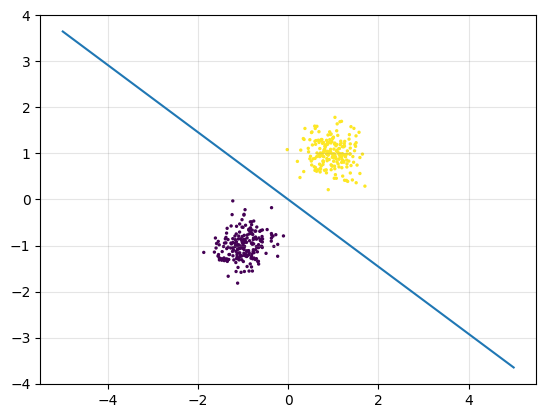

In [14]:
hp1= HardPerceptron(len(F_train_linsep[0]))
hp1.train(F_train_linsep, y_train_linsep)

plt.scatter(F_train_linsep[:, 0], F_train_linsep[:, 1], c=y_train_linsep, s=2)
plt.grid(c='.5', alpha=.2)
x1 = np.linspace(-5,5,10000)
plt.plot(x1, - hp1.w[0]/hp1.w[1] * x1 - hp1.b/hp1.w[1])#p=0.5

print('Average binary cross entropy of training set')
print(hp1.AverageBCE(F_train_linsep, y_train_linsep))
print('Average binary cross entropy of test set')
print(hp1.AverageBCE(F_test_linsep, y_test_linsep))


### Section 3

In this section, repeat the same steps as in Section 2, but using the **soft perceptron**.  

**Note:** You do **not** need to re-implement the soft perceptron. Simply use the existing implementation.  

The steps are:  
- Train the soft perceptron on the training set of the linearly separable dataset.  
- Plot the decision boundary using the same training set.  
- Evaluate the cross-entropy loss on both the **training** and **test** sets.  


Average binary cross entropy of training set
0.00011109290311717718
Average binary cross entropy of test set
0.00015515918396083459


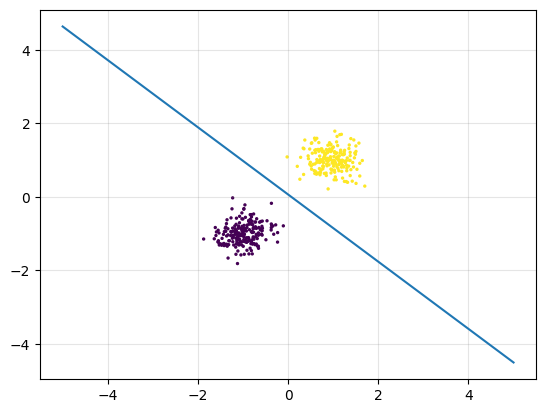

In [25]:
sfh= SoftPerceptron(len(F_train_linsep[0]))
sfh.train(F_train_linsep, y_train_linsep)

plt.scatter(F_train_linsep[:, 0], F_train_linsep[:, 1], c=y_train_linsep,s=2)
plt.grid(c='.5', alpha=.2)
x1 = np.linspace(-5,5,10000)
plt.plot(x1, - sfh.w[0]/sfh.w[1] * x1 - sfh.b/sfh.w[1] )#p=0.5

print('Average binary cross entropy of training set')
print(sfh.AverageBCE(F_train_linsep, y_train_linsep))
print('Average binary cross entropy of test set')
print(sfh.AverageBCE(F_test_linsep, y_test_linsep))


### Section 4

Repeat the procedures from **Sections 2 and 3**, but this time using the **non-linearly separable dataset**.  

Once completed, answer the following questions:

- Which perceptron achieves a lower loss on the linearly separable dataset? Why?
- Which perceptron achieves a lower loss on the non-linearly separable dataset? Why?

HARD PERCEPTRON
Average binary cross entropy of training set
1.784503445714681
Average binary cross entropy of test set
3.9143946548632558


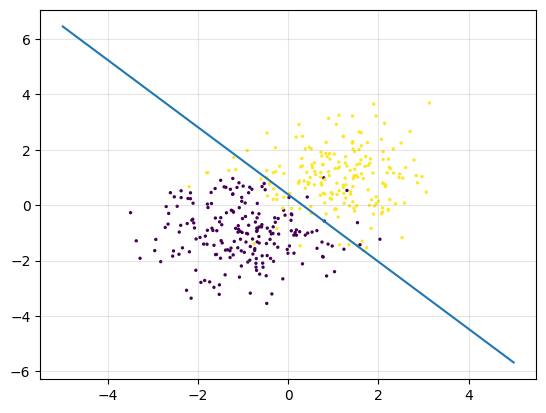

SOFT PERCEPTRON
Average binary cross entropy of training set
0.21788241354874407
Average binary cross entropy of test set
0.460849746302847


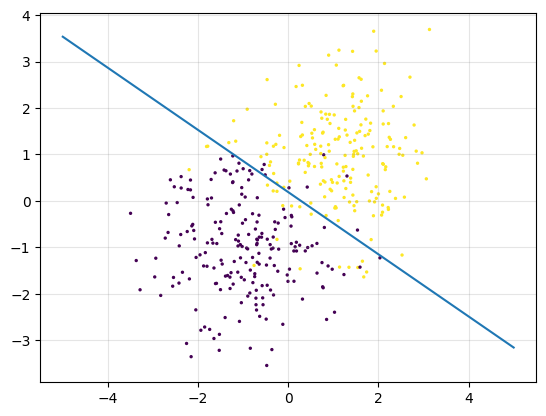

In [23]:
#HARD PERCEPTRON

hp1= HardPerceptron(len(F_train_nonlinsep[0]))
hp1.train(F_train_nonlinsep, y_train_nonlinsep)

plt.scatter(F_train_nonlinsep[:, 0], F_train_nonlinsep[:, 1], c=y_train_nonlinsep, s=2)
plt.grid(c='.5', alpha=.2)
x1 = np.linspace(-5,5,10000)
plt.plot(x1, - hp1.w[0]/hp1.w[1] * x1 - hp1.b/hp1.w[1])#p=0.5
print('HARD PERCEPTRON')
print('Average binary cross entropy of training set')
print(hp1.AverageBCE(F_train_nonlinsep, y_train_nonlinsep))
print('Average binary cross entropy of test set')
print(hp1.AverageBCE(F_test_nonlinsep, y_test_nonlinsep))


plt.show()


#SOFT PERCEPTRON 
print('SOFT PERCEPTRON')
sfh= SoftPerceptron(len(F_train_linsep[0]))
sfh.train(F_train_nonlinsep, y_train_nonlinsep)

plt.scatter(F_train_nonlinsep[:, 0], F_train_nonlinsep[:, 1], c=y_train_nonlinsep,s=2)
plt.grid(c='.5', alpha=.2)
x1 = np.linspace(-5,5,10000)
plt.plot(x1, - sfh.w[0]/sfh.w[1] * x1 - sfh.b/sfh.w[1] )
print('Average binary cross entropy of training set')
print(sfh.AverageBCE(F_train_nonlinsep, y_train_nonlinsep))
print('Average binary cross entropy of test set')
print(sfh.AverageBCE(F_test_nonlinsep, y_test_nonlinsep))


**Which perceptron achieves a lower loss on the linearly separable dataset? Why?**
The hard perceptron has a lower loss on the lineraly seperale dataset becasue the steep decision boundary between labels matches the dataset and supposes virtually no loss once trained and lower loss in training set as well. 
**Which perceptron achieves a lower loss on the non-linearly separable dataset? Why?**
The soft perceptron achieves a lower loss than the hard perceptron when testing on a non-linerarly seperable dataset.
Because the softperceptron accepts a probability for the label being 1, ther is greater flexibility for a boundary where there is uncertainty. 
